In [1]:
# https://www.kaggle.com/datasets/christofferms/pokemon-with-stats-and-image/data

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import silhouette_score, calinski_harabasz_score
from sklearn.cluster import KMeans, SpectralClustering
from category_encoders import BinaryEncoder

data = pd.read_csv("pokedex.csv")

data = data.iloc[:, 2:]
data = data.rename(columns={"Type 1": "FirstEl", "Type 2": "SecondEl"})

data

,Name,FirstEl,SecondEl,Total,HP,Attack,Defense,SP. Atk.,SP. Def,Speed
0,Bulbasaur,Grass,Poison,318,45,49,49,65,65,45
1,Ivysaur,Grass,Poison,405,60,62,63,80,80,60
2,Venusaur,Grass,Poison,525,80,82,83,100,100,80
3,Venusaur Mega Venusaur,Grass,Poison,625,80,100,123,122,120,80
4,Charmander,Fire,NaN,309,39,52,43,60,50,65
...,...,...,...,...,...,...,...,...,...,...
1210,Iron Crown,Steel,Psychic,590,90,72,100,122,108,98
1211,Terapagos Normal Form,Normal,NaN,450,90,65,85,65,85,60
1212,Terapagos Terastal Form,Normal,NaN,600,95,95,110,105,110,85
1213,Terapagos Stellar Form,Normal,NaN,700,160,105,110,130,110,85


Snažil jsem se najít si vlastní dataset, který by mě zajímal a nakonec jsem nečekaně skončil u pokémonů, kde jsem si řekl, že by to mohl být zajímavý dataset na analýzu. Dataset obsahuje pokémony z 1-9 řady pokémonů.

Konkrétně u tohoto datasetu máme záznam o 1215 pokémonech s tím, že známe typy pokémonů, jejich podrobné statistiky, takže budeme schopni určit trend pokémonů, kterých je nejvíce, kteří jsou nejsilnější a poté utvořit shlukování, které pravděpodobně bude shlukovat podle typů pokémonů.

U datasetu máme celkově 12 sloupců, kde rovnou dropnu 1. sloupec s "Image", protože pro mé účely není vůbec potřeba tento sloupec s odkazem na obrázek k danému pokémonovi mít. Taktéž "Index" sloupec hned následující dropnu, protože číselné označení pokémonů pro mě nemá žádný význam.

Po očištění datasetu nám tedy zbývá 9 sloupců.

Type 1 - 1. typ (element) pokémona

Type 2 - ... (může být NaN)

Total - součet všech hodnot (Dá se říct měřítko síly pokémona celkově)

HP - životy pokémona

Attack - Poškození pokémona

Defense - Obrana pokémona

SP. Atk. - Poškození pomocí schopnosti

SP. Def - Obrana proti schopnostem

Speed - Rychlost pohybu pokémona

Sloupec (Type 1, Type 2) si dovolím přejmenovat na FirstEl a SecondEl.

In [2]:
data.isna().sum()

Name          0
FirstEl       0
SecondEl    546
Total         0
HP            0
Attack        0
Defense       0
SP. Atk.      0
SP. Def       0
Speed         0
dtype: int64

Jak můžeme vidět, všechny sloupce až na SecondEl mají hodnoty. Jelikož je pro nás 2. sloupec celkem důležitý a nechci se ho zbavit, vyplním veškeré chybějí hodnoty třeba stringem "null" a později ho můžu vyfiltrovat v grafech a různých ukázkách a počtech.

In [3]:
data.fillna("None", inplace=True)

sum(1 if " Mega " in word else 0 for word in data["Name"])    # Spočítání slova " Mega " ve jméně

48

Nyní je všechno nahrazené za "None" hodnoty.

V tuto chvíli mě tak ale napadlo, že bych mohl dataset sám rozšířit o nové sloupce. Pokémoni totiž mají své vylepšení a potom i "Mega" formy, které jsou víceméně jejich vylepšená verze. Přidám proto nový sloupec, který určuje, zdali je pokémon v mega formě nebo ne. Z mého dotazu je vidět, že z 1215 pokémonů má 48 Mega formu. Mám jistotu, že pokémon neobsahuje slovo Mega, protože se ptám na " Mega ", což znamená, že má před i po slově "Mega" nějaké další slova, což všichni pokémoni mají, pokud mají v názvu Mega formu. Ale tím eliminuji omylem zahrnout pokémony třeba s názvem "Meganium"

In [4]:
data["Mega"] = [1 if " Mega " in word else 0 for word in data["Name"]]

data.insert(3, "Mega", data.pop("Mega"))

data

,Name,FirstEl,SecondEl,Mega,Total,HP,Attack,Defense,SP. Atk.,SP. Def,Speed
0,Bulbasaur,Grass,Poison,0,318,45,49,49,65,65,45
1,Ivysaur,Grass,Poison,0,405,60,62,63,80,80,60
2,Venusaur,Grass,Poison,0,525,80,82,83,100,100,80
3,Venusaur Mega Venusaur,Grass,Poison,1,625,80,100,123,122,120,80
4,Charmander,Fire,None,0,309,39,52,43,60,50,65
...,...,...,...,...,...,...,...,...,...,...,...
1210,Iron Crown,Steel,Psychic,0,590,90,72,100,122,108,98
1211,Terapagos Normal Form,Normal,None,0,450,90,65,85,65,85,60
1212,Terapagos Terastal Form,Normal,None,0,600,95,95,110,105,110,85
1213,Terapagos Stellar Form,Normal,None,0,700,160,105,110,130,110,85


Tady vidíme nový dataset se sloupcem, který určuje "Mega" toho, jestli pokémon je či není.

Nyní půjdeme dataset prozkoumat pomocí grafů a prvně se zaměřím na rozdělení elementů u pokémonů

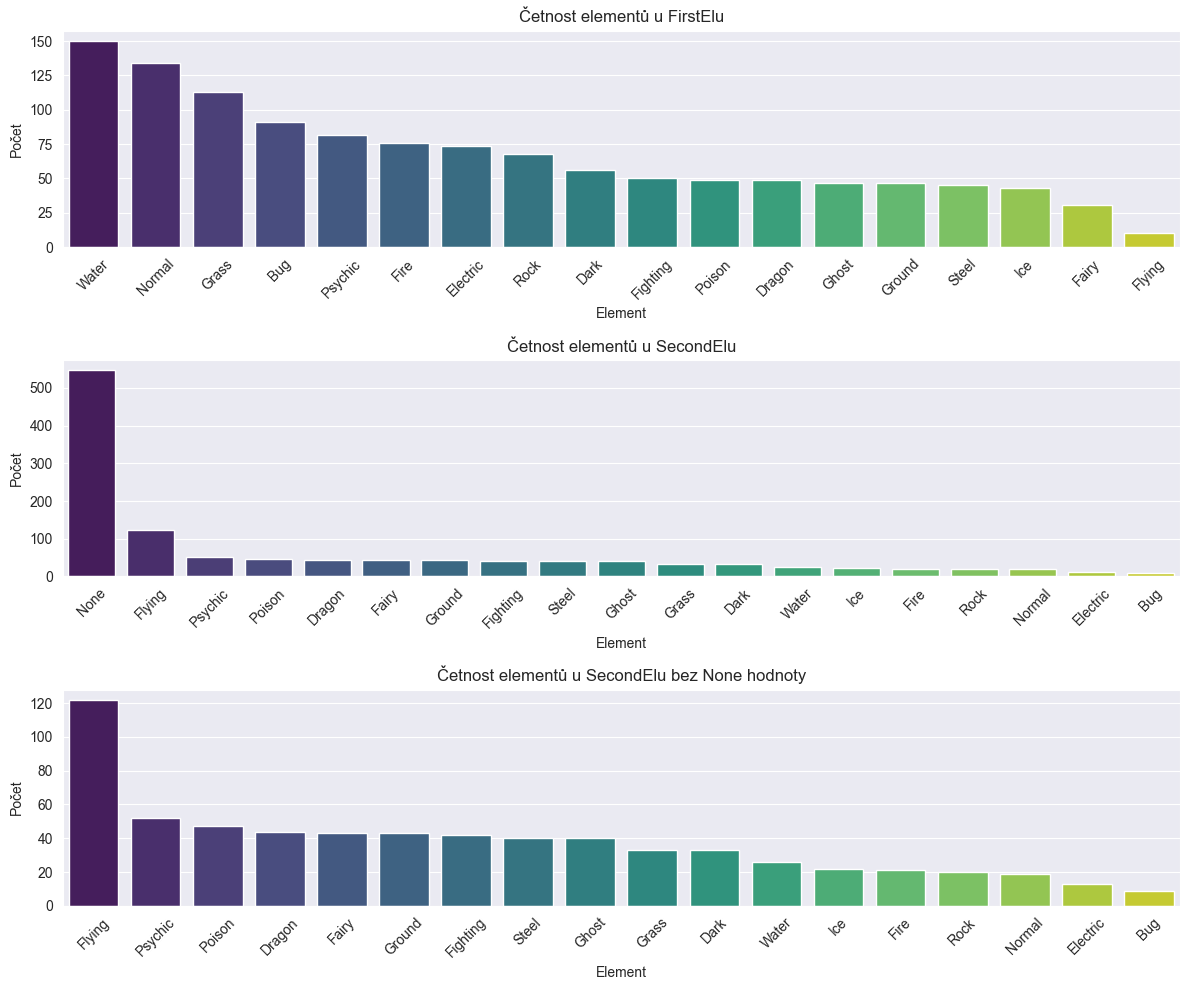

In [5]:
first_el = data["FirstEl"].value_counts()
second_el = data["SecondEl"].value_counts()
second_el_without_none = data["SecondEl"].value_counts().iloc[1:]

plt.figure(figsize=(12, 10))

plt.subplot(3, 1, 1)
sns.barplot(x=first_el.index, y=first_el.values, hue=first_el.index, legend=False, palette="viridis")
plt.title("Četnost elementů u FirstElu")
plt.xlabel("Element")
plt.ylabel("Počet")
plt.xticks(rotation=45)

plt.subplot(3, 1, 2)
sns.barplot(x=second_el.index, y=second_el.values, hue=second_el.index, legend=False, palette="viridis")
plt.title("Četnost elementů u SecondElu")
plt.xlabel("Element")
plt.ylabel("Počet")
plt.xticks(rotation=45)

plt.subplot(3, 1, 3)
sns.barplot(x=second_el_without_none.index, y=second_el_without_none.values, hue=second_el_without_none.index, legend=False, palette="viridis")
plt.title("Četnost elementů u SecondElu bez None hodnoty")
plt.xlabel("Element")
plt.ylabel("Počet")
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

Jak vidíme, z 1. grafu četnosti podle 1. elementu je celkem zajímavé, že převládají zrovna vodní pokémoni a graf má celkem tvar funkce (1/x). To samé se dá říct o 3. grafu, kde ale ten rozdíl není na tolik markantní.

Ten 2. graf je čistě pro ukázku jak moc převládá prázdný element u 2. elementu.

In [6]:
none_count = second_el.iloc[0]
others = sum(second_el.iloc[1:])
total = none_count + others

print(none_count / total * 100)

44.93827160493827


Skoro 45% pokémonů nemá 2. typ.

Než se vrhnu na práci s čísly statistik jednotlivých pokémonů, ještě bych se chtěl pozastavit nad rozložením "síly". Pokémoni totiž mají svojí sílu v sloupci "Total", podle které se dá víceméně měřit síla jednotlivých pokémonů. Zkusíme tedy vykreslit to a uvidíme jaké je rozložení.

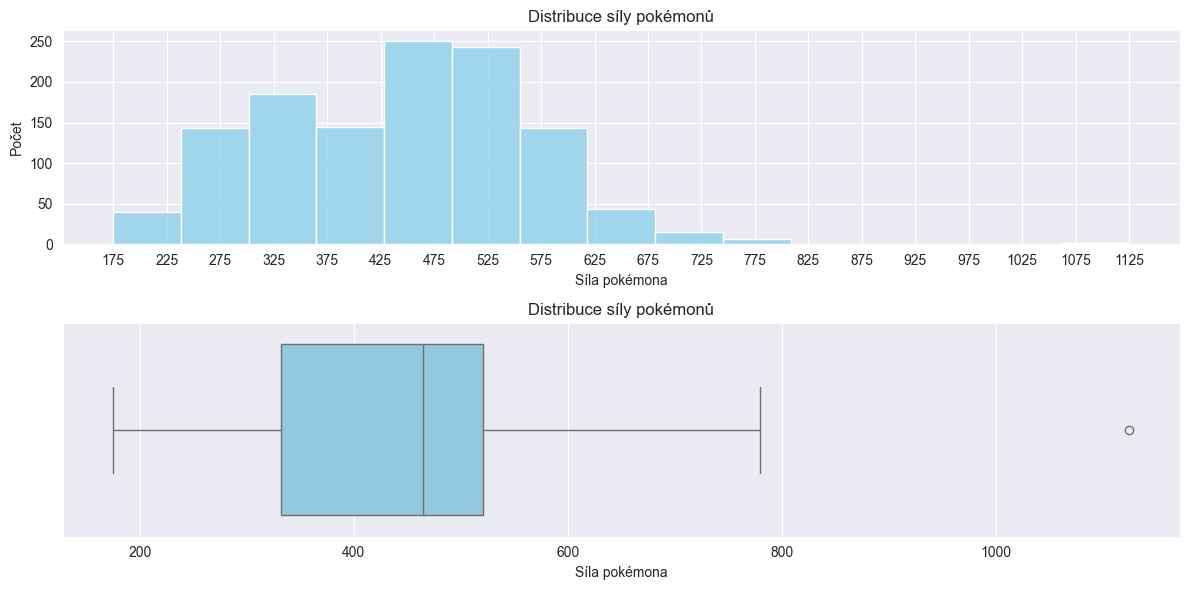

In [7]:
plt.figure(figsize=(12, 6))

plt.subplot(2, 1, 1)
sns.histplot(data["Total"], bins=15, color="skyblue")
plt.title("Distribuce síly pokémonů")
plt.xlabel("Síla pokémona")
plt.xticks(range(min(data["Total"]), max(data["Total"]) + 1, 50))
plt.ylabel("Počet")

plt.subplot(2, 1, 2)
sns.boxplot(x=data["Total"], color="skyblue")
plt.title("Distribuce síly pokémonů")
plt.xlabel("Síla pokémona")
plt.tight_layout()
plt.show()

Vidíme, že distribuce síly pokémonů je nejsilnější mezi 400 a 600, což je víceméně průměr hodnoty (+- 0-1200), dalo by se říct, že je zde vidět i přirozené rozdělení (Gaussovu křivku) v kterou jsem tak trochu doufal, že bych ji tu mohl najít. ALE vidíme jednoho osamělého pokémona, který je outlier a výjimka oproti všem svým pokémonům, tak se podíváme, kdo to je.



In [8]:
print(data.loc[data["Total"].idxmax()])

Name        Eternatus Eternamax
FirstEl                  Poison
SecondEl                 Dragon
Mega                          0
Total                      1125
HP                          255
Attack                      115
Defense                     250
SP. Atk.                    125
SP. Def                     250
Speed                       130
Name: 1058, dtype: object


Pokémon Eternatus Eternamax je očividně velmi silný oproti zbytku pokémonům. V této situaci, než budeme pokračovat dál, by bylo dobré se zaměřit na outliery, ale upřímně, tento dataset je natolik hezky rozdělený, že toto je víceméně jediný outlier, který tu leží. Odstranil bych ho proto ručně a zbytek nechám. Ještě jednou ukážu distribuci bez outliera.

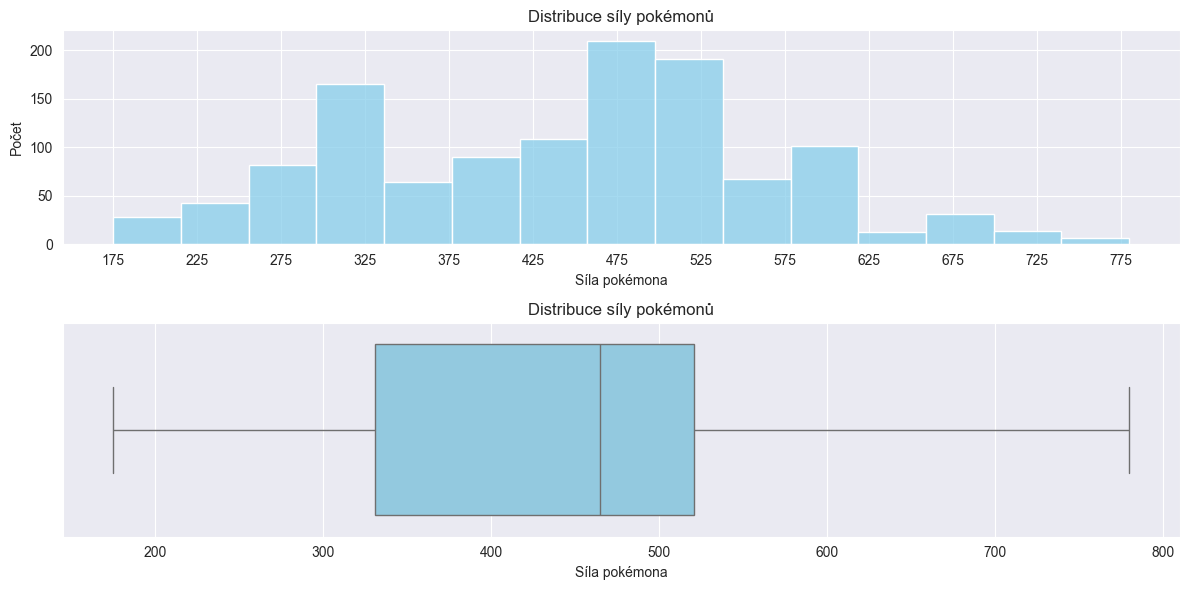

In [9]:
outlier_id = data["Total"].idxmax()

data.drop(outlier_id, inplace=True)

plt.figure(figsize=(12, 6))

plt.subplot(2, 1, 1)
sns.histplot(data["Total"], bins=15, color="skyblue")
plt.title("Distribuce síly pokémonů")
plt.xlabel("Síla pokémona")
plt.xticks(range(min(data["Total"]), max(data["Total"]) + 1, 50))
plt.ylabel("Počet")

plt.subplot(2, 1, 2)
sns.boxplot(x=data["Total"], color="skyblue")
plt.title("Distribuce síly pokémonů")
plt.xlabel("Síla pokémona")
plt.tight_layout()
plt.show()

Nyní vidíme tedy dataset očištěný o jediného outliera. Přesuneme se od grafů ke korelační matici, která by nám mohla ukázat, jak na sobě závislý jednotlivé parametry pokémona s jeho elementem a nebo jak jsou na sobě jednotlivé parametry závislé.

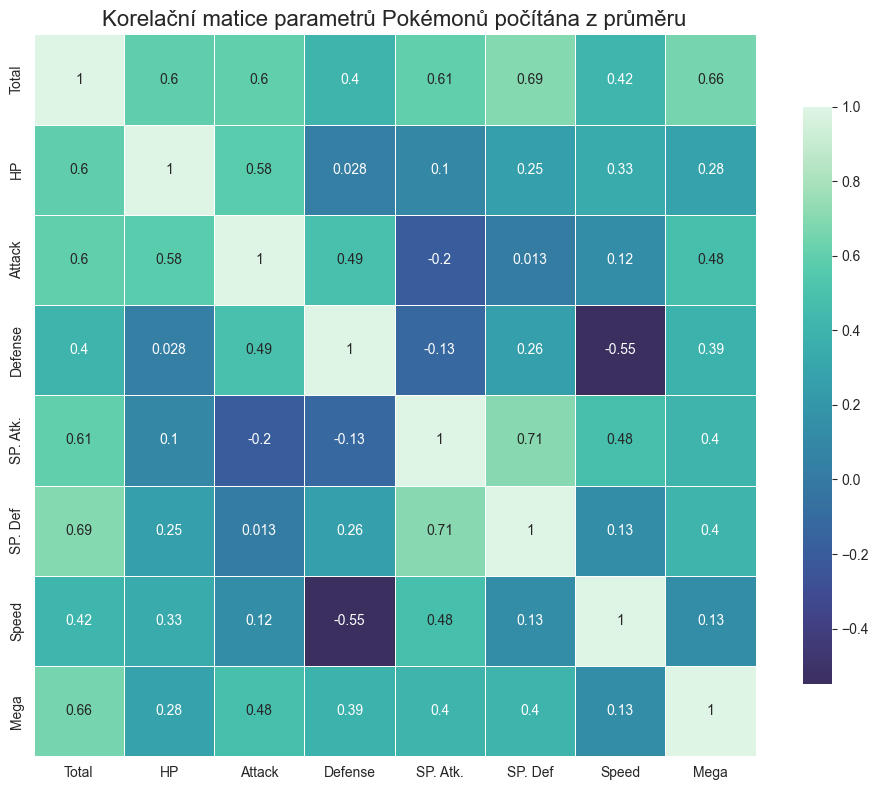

In [10]:
type_averages = data.groupby("FirstEl")[["HP", "Attack", "Defense", "SP. Atk.", "SP. Def", "Speed", "Total", "Mega"]].mean()
correlation_matrix = type_averages[["Total", "HP", "Attack", "Defense", "SP. Atk.", "SP. Def", "Speed", "Mega"]].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="mako", center=0, 
            square=True, linewidths=0.5, cbar_kws={"shrink": .8})
plt.title("Korelační matice parametrů Pokémonů počítána z průměru", fontsize=16)
plt.tight_layout()
plt.show()

Můžeme vidět negativní korelaci mezi defense a speed, tudíž jsou to víceméně 2 rozdílné atributy. Buď je pokémon rychlý, nebo je odolný. Kombinace toho se prakticky neděje. 

Pozitivní korelace je u SP. Atk. a Sp. Def to znamená, že pokud pokémon má silné schopnosti, má i silnou obranu proti nim.

Taktéž vidíme, že náš nový sloupec (Mega) tak je nejvíce ovlivněn útokem, ale bohužel moc mega pokémonů v záznamech nemáme (48). Je celkem nepřekvapivé, že mega pokémon bude silný na útok. Dá se to očekávat. Taktéž hodně přispívá do Total hodnoty (celkové síly pokémona)

Zkusíme ale jinou korelační matici. Toto jsou korelace mezi základními atributy všech pokémonů, ale co kdybychom udělali korelaci ke každému ELEMENTU pokémona? Korelačních matic bude skutečně hodně, ale aspoň z nich uvidíme, jestli nějaký typ má nějaké tendence že něco spolu lineárně roste, nebo klesá.

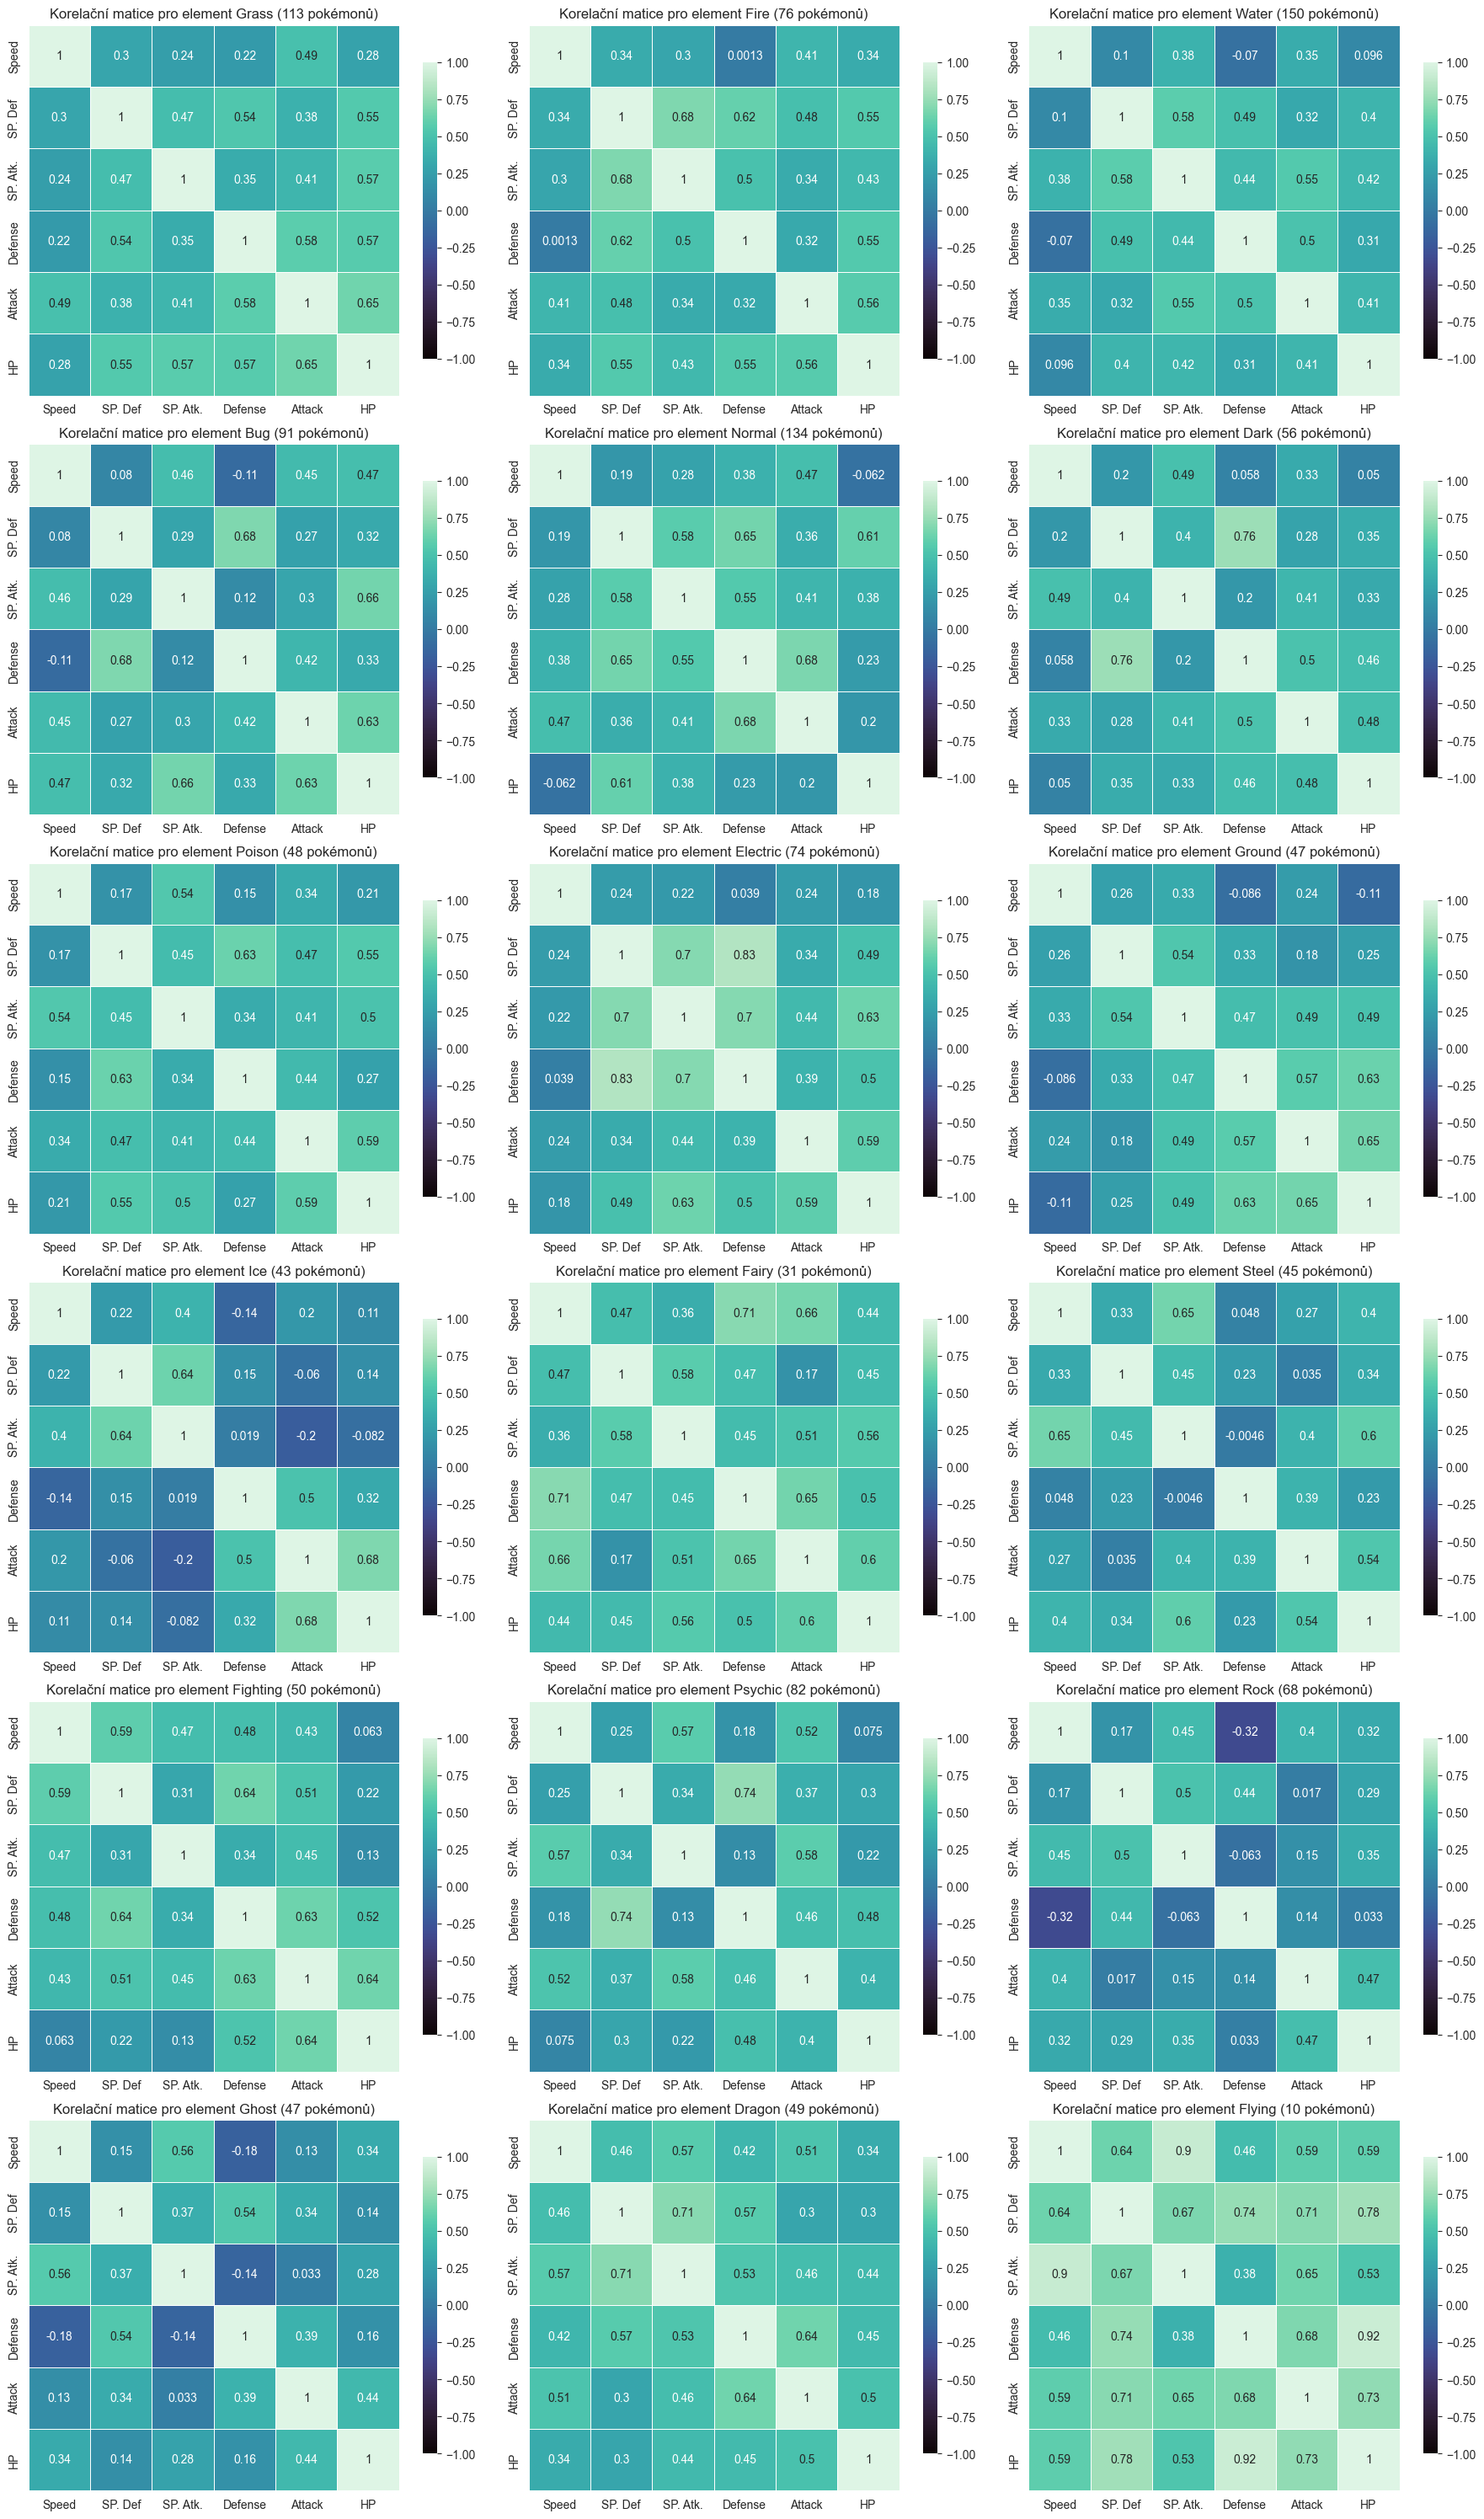

In [19]:
to_correlate = ["Speed", "SP. Def", "SP. Atk.", "Defense", "Attack", "HP"]
elements = data["FirstEl"].unique()

rows = math.ceil(len(elements) / 3)

plt.figure(figsize=(18, 5 * rows))

for index, element in enumerate(elements):
    plt.subplot(rows, 3, index + 1)
    
    type_data = data[data["FirstEl"] == element]
    corr_mat = type_data[to_correlate].corr(method="pearson")
    
    sns.heatmap(corr_mat, annot=True, cmap="mako", center=0, 
                square=True, linewidths=0.5, cbar_kws={"shrink": .8},
                vmin=-1, vmax=1)
    
    plt.title(f"Korelační matice pro element {element} ({len(type_data)} pokémonů)")
    
plt.tight_layout()
plt.show()


Vidíme, že u flying je těch korelací hodně, ale to bude způsobeno tím, že flying pokémoni nejsou skoro zastoupeni v hlavním elementu (FirstEl) ale v sekundárním elementu. Tudíž matici pro flying bych trochu ignoroval.

Ale nějaké zajímavosti aspoň trochu:

Dark a Psychic pokémoni mají víceméně skoro stejně defense a defense proti schopnostem, je tam velká korelace (čím větší mají defense, tím větší mají i obranu proti schopnostem)

U Rock pokémonů můžeme vidět dokonce negativní korelaci, čím větší Defense, tím menší speed (a naopak)

Zkusíme úplně poslední část této analýzy. Uděláme grafy pro všechny atributy a podíváme se na průměrnou distribuci pro každý jednotlivý element. Tady budeme mít teprve šanci vidět, že např. ohniví pokémoni mají největší poškození



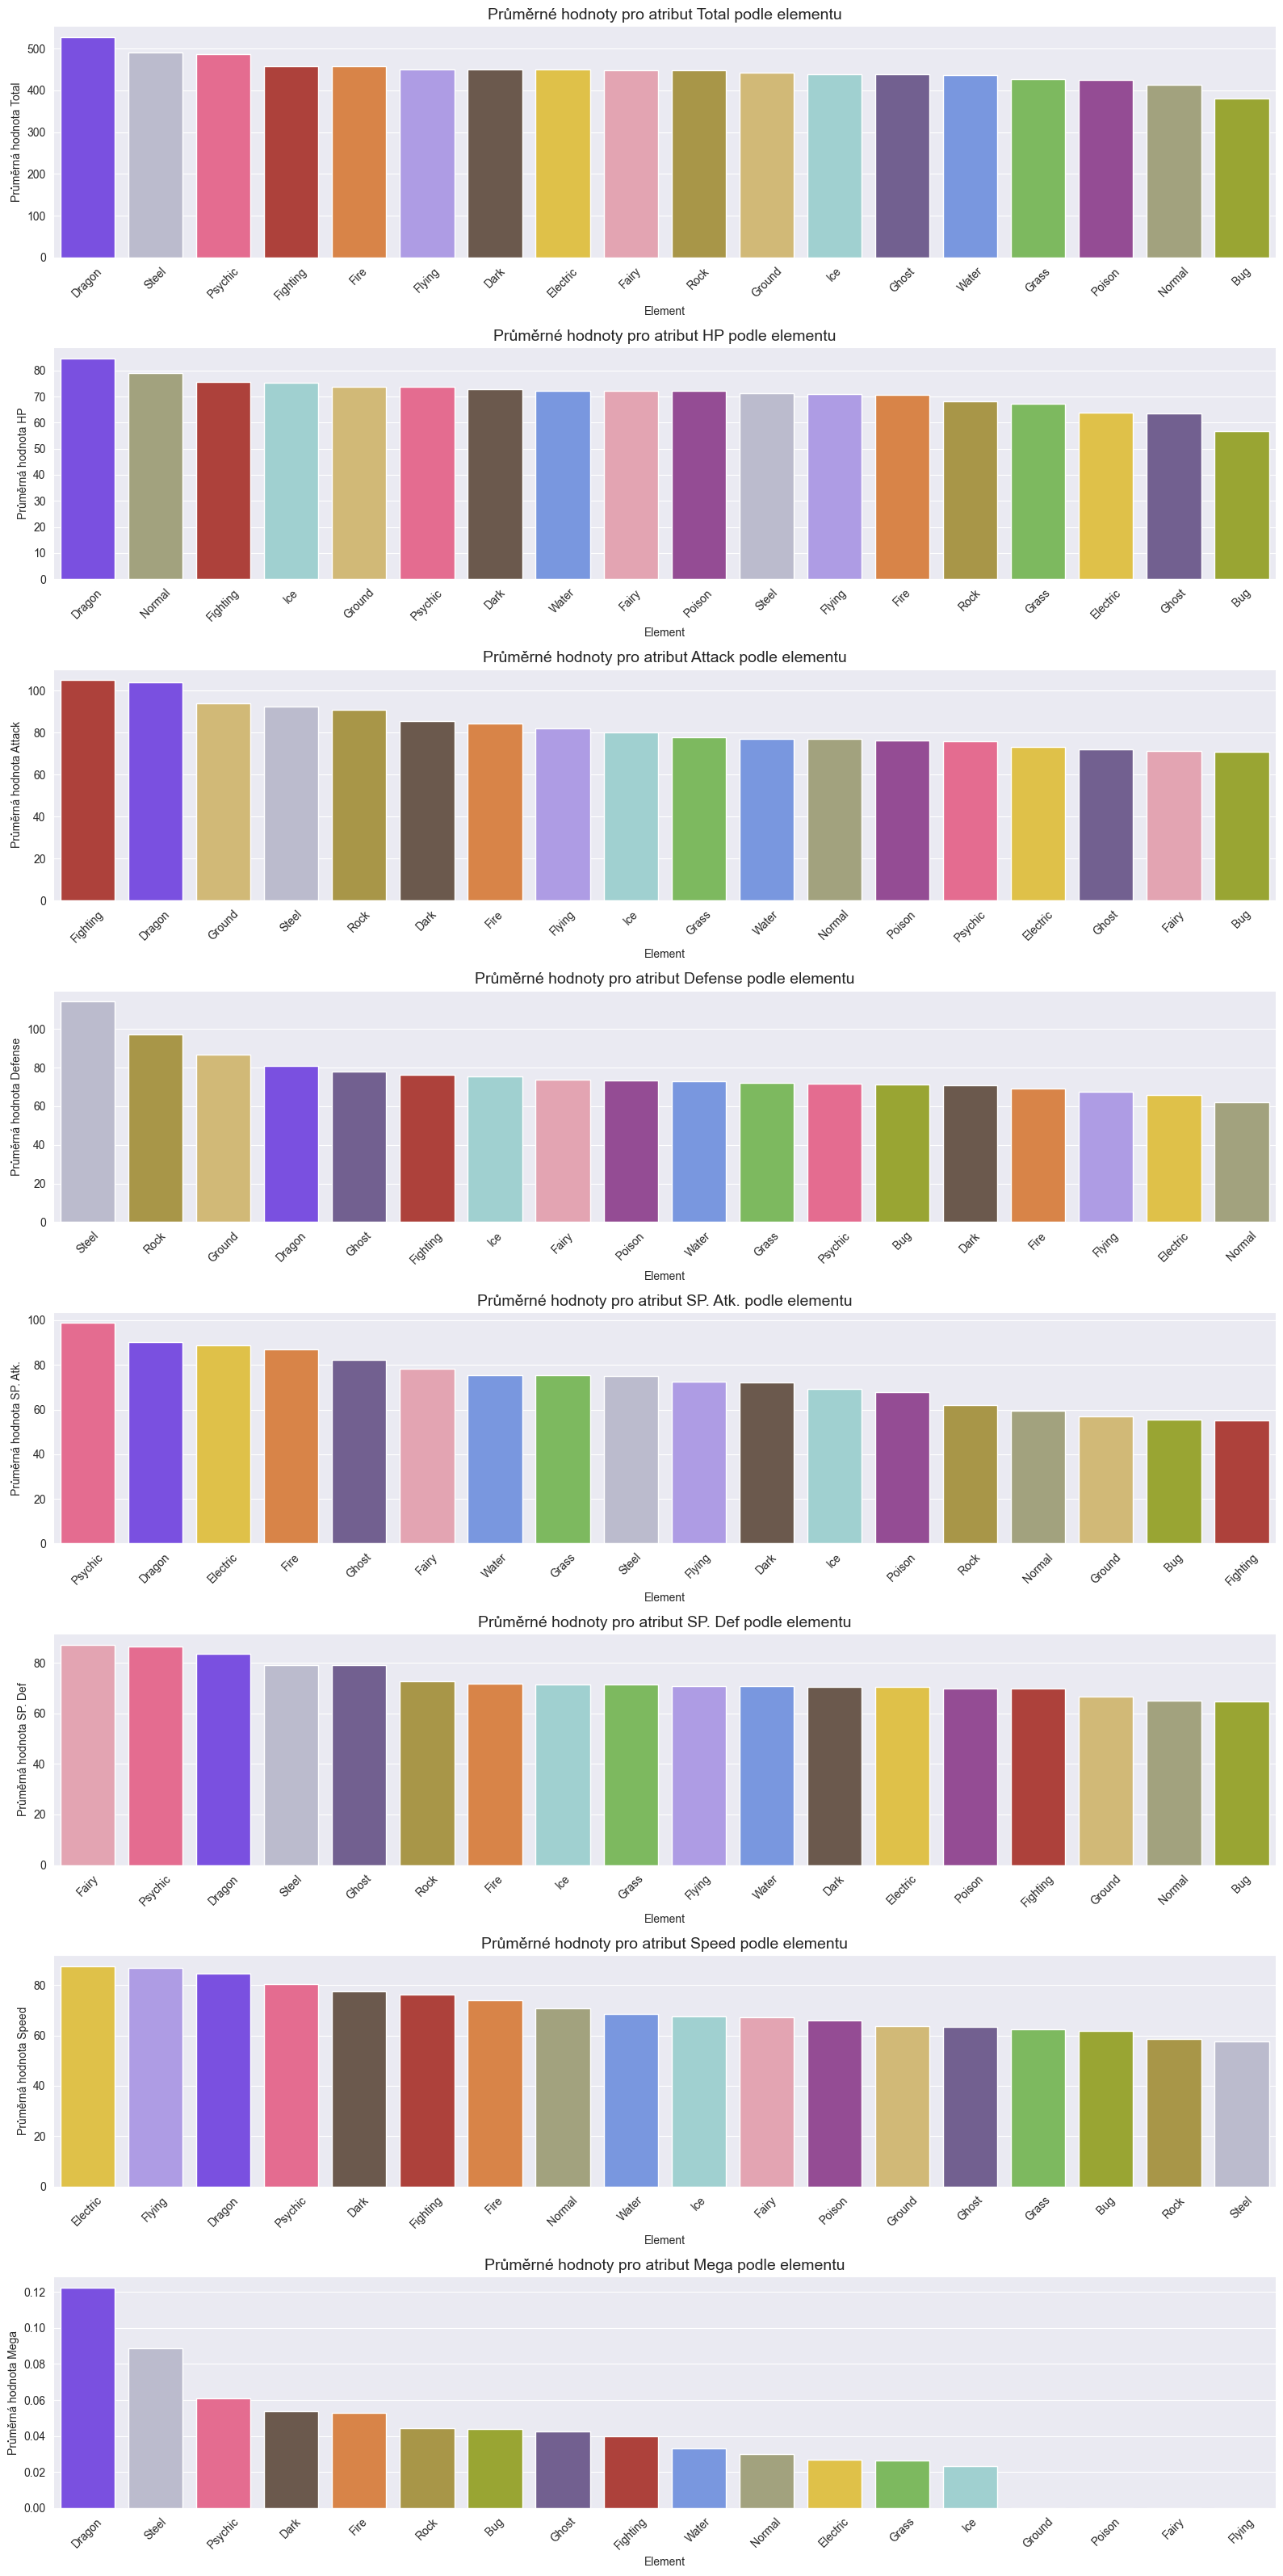

In [12]:
attributes = ["Total", "HP", "Attack", "Defense", "SP. Atk.", "SP. Def", "Speed", "Mega"]

element_colors = {
    "Grass": "#78C850", "Fire": "#F08030", "Water": "#6890F0", "Bug": "#A8B820", 
    "Normal": "#A8A878", "Dark": "#705848", "Poison": "#A040A0", 
    "Electric": "#F8D030", "Ground": "#E0C068", "Ice": "#98D8D8", 
    "Fairy": "#EE99AC", "Steel": "#B8B8D0", "Fighting": "#C03028", 
    "Psychic": "#F85888", "Rock": "#B8A038", "Ghost": "#705898", 
    "Dragon": "#7038F8", "Flying": "#A890F0"
}

plt.figure(figsize=(16, 4 * len(attributes)))

for index, attribute in enumerate(attributes):
    plt.subplot(len(attributes), 1, index + 1)
    
    means = data.groupby("FirstEl")[attribute].mean().reindex(elements).sort_values(ascending=False)
    
    sns.barplot(
        x=means.index, y=means.values, 
        hue=means.index, dodge=False, legend=False, 
        palette=[element_colors[el] for el in means.index]
    )
    
    plt.title(f"Průměrné hodnoty pro atribut {attribute} podle elementu", fontsize=14)
    plt.ylabel(f"Průměrná hodnota {attribute}")
    plt.xlabel("Element")
    plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

Než začneme s postřehy, chtěl bych ukázat na to, co jsme viděli v korelační matici.
Např. Psychic a Dark korelační matice říkala, že se zvyšující defense mají i větší defense proti schopnostem. Když se podíváme na Dark a Psychic do grafů Defense a SP. Def, vidíme, že jejich defense a SP. Def je skoro na té samé hodnotě. Tudíž to odpovídá tomu, co říkala matice.

Když se podíváme na Rock, tak vidíme, že Rock má velký defense (top 2), ale malý speed (2. nejhorší), což jsme viděli na korelační matici, kde byla záporná korelace. Tudíž by měl převyšovat jen jeden z těchto atributů a tak se i děje.

Nyní k postřehům ze samotných sloupcových grafů.

Dragon pokémoni bývají overall nejsilnější (taktéž jsou nejčastějí mega pokémoni)

Bug pokémoni jsou overall nejslabší, skoro ve všech statistikách jsou na spodu.

Překvapivě, flying pokémon nejsou nejrychlejší, ale jsou to electric pokémoni

Defense největší mají steel, ground, rock, celkem očekávatelné

Ale vidíme, že Psychic pokémoni jsou celkem dost silní, většinou jsou uprostřed nebo jedni z prvních ve statistikách průměrných. 

Hezké vidět je, že většina mega pokémonů je typu Dragon a je dokonce vidět, že někteří nemají ani zástupce (alespoň v primárním atributu)

Tak a toto je víceméně konec toho, co jsme schopni získat z daného datasetu za informace co se týče grafové analýzy. 

V celé analýze jsem trochu zanedbával 2. atribut u pokémona, protože polovina je ho tvořena prázdnými hodnotami a myslím si, že není zas tak důležitá. Avšak pro ještě hlubší analýzu by se dal zahrnout i 2. atribut a udělat celou analýzu s oběma atributy a potom porovnat rozdíl. Podle mého názoru to ale nepřinese moc zajímavé výsledky. Taktéž mě napadlo sečíst atributy 1. a 2. dohromady, což by ale mohlo zanést trošku špatné informace do datasetu a proto jsem to neudělal.

Vrhneme se na clustering a předpřipravení dat, jelikož FirstEl a SecondEl jsou textové hodnoty a ostatní čísla nejsou moc hezky rozložená hodnotami

Myslím si, že nějaký cluster bude tvořený určitě pokémony 2. typu, kteří nemají žádný atribut (null) nebo taky nějaký cluster bude tvořen pokémony, co jsou mega (těch je jen 48 z 1214, 1 outlier dropnut), ale jinak si netroufám říct, podle čeho jiného by se clustering mohl dít, možná i podle elementů?

Podíváme se znovu na naše data



In [13]:
data

,Name,FirstEl,SecondEl,Mega,Total,HP,Attack,Defense,SP. Atk.,SP. Def,Speed
0,Bulbasaur,Grass,Poison,0,318,45,49,49,65,65,45
1,Ivysaur,Grass,Poison,0,405,60,62,63,80,80,60
2,Venusaur,Grass,Poison,0,525,80,82,83,100,100,80
3,Venusaur Mega Venusaur,Grass,Poison,1,625,80,100,123,122,120,80
4,Charmander,Fire,None,0,309,39,52,43,60,50,65
...,...,...,...,...,...,...,...,...,...,...,...
1210,Iron Crown,Steel,Psychic,0,590,90,72,100,122,108,98
1211,Terapagos Normal Form,Normal,None,0,450,90,65,85,65,85,60
1212,Terapagos Terastal Form,Normal,None,0,600,95,95,110,105,110,85
1213,Terapagos Stellar Form,Normal,None,0,700,160,105,110,130,110,85


V této části už skutečně můžeme odstranit jméno, protože s ním nemáme co dělat.

Element 1. a 2. předěláme pomocí binary encodingu na binární reprezentaci. Oproti OneHot nevytváří tolik sloupců a clustering by mohl být hezčí. 
Jelikož OneHot by vytvořil (2 * 18) sloupců a s binary encodingem máme pouze (2 * log2(18)**) sloupců. Při použití OneHot mi clustering přišel velmi chaotický a nehezký.
Bohužel u binary encodingu ztrácíme schopnost reprezentovat data. 

Číselné hodnoty pomocí MinMax přeškálujeme na hodnoty o podobné velikosti.

** log2(18) = 5 po zaokrouhlení

In [14]:
data = data.iloc[:, 1:]

encoder = BinaryEncoder(cols=['FirstEl', 'SecondEl'])
data_encoded = encoder.fit_transform(data)

scaler = MinMaxScaler()

data_encoded[["Total", "HP", "Attack", "Defense", "SP. Atk.", "SP. Def", "Speed"]] = scaler.fit_transform(data_encoded[["Total", "HP", "Attack", "Defense", "SP. Atk.", "SP. Def", "Speed"]])

data_encoded


,FirstEl_0,FirstEl_1,FirstEl_2,FirstEl_3,FirstEl_4,SecondEl_0,SecondEl_1,SecondEl_2,SecondEl_3,SecondEl_4,Mega,Total,HP,Attack,Defense,SP. Atk.,SP. Def,Speed
0,0,0,0,0,1,0,0,0,0,1,0,0.236364,0.173228,0.237838,0.195556,0.298913,0.214286,0.205128
1,0,0,0,0,1,0,0,0,0,1,0,0.380165,0.232283,0.308108,0.257778,0.380435,0.285714,0.282051
2,0,0,0,0,1,0,0,0,0,1,0,0.578512,0.311024,0.416216,0.346667,0.489130,0.380952,0.384615
3,0,0,0,0,1,0,0,0,0,1,1,0.743802,0.311024,0.513514,0.524444,0.608696,0.476190,0.384615
4,0,0,0,1,0,0,0,0,1,0,0,0.221488,0.149606,0.254054,0.168889,0.271739,0.142857,0.307692
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1210,0,1,1,0,0,0,0,1,1,0,0,0.685950,0.350394,0.362162,0.422222,0.608696,0.419048,0.476923
1211,0,0,1,0,1,0,0,0,1,0,0,0.454545,0.350394,0.324324,0.355556,0.298913,0.309524,0.282051
1212,0,0,1,0,1,0,0,0,1,0,0,0.702479,0.370079,0.486486,0.466667,0.516304,0.428571,0.410256
1213,0,0,1,0,1,0,0,0,1,0,0,0.867769,0.625984,0.540541,0.466667,0.652174,0.428571,0.410256


Veškeré kategorické hodnoty jsme převedli díky BinaryEncodingu a MinMax pro škálování číselných hodnot. 

Můžeme započít prvním krokem a to KMeans - Elbow Method

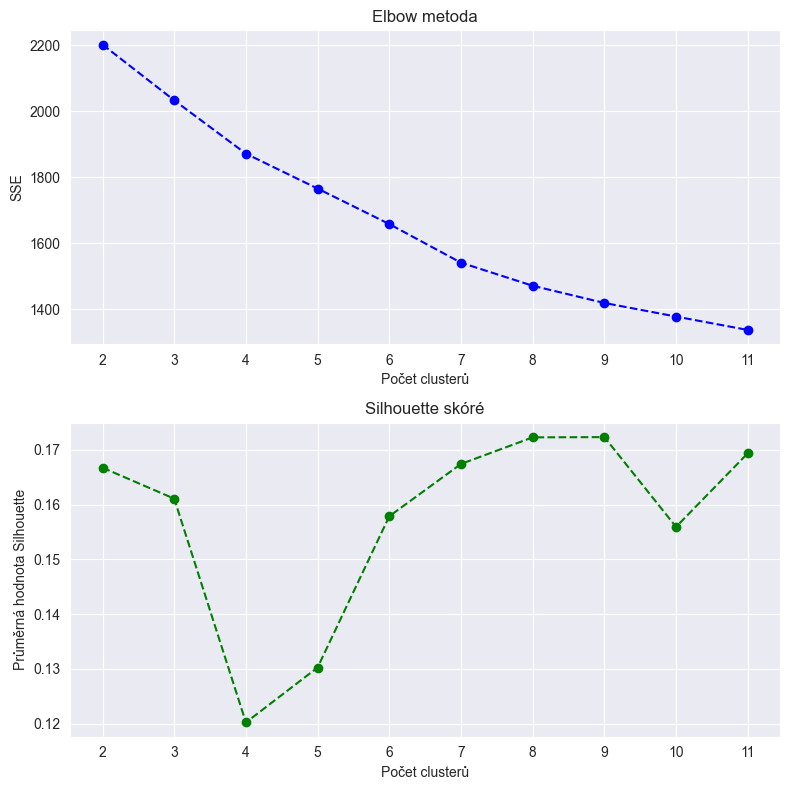

In [15]:
sse = []
silhouette_avg = []  
k_values = range(2, 12)  

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(data_encoded)
    sse.append(kmeans.inertia_)
    
    score = silhouette_score(data_encoded, kmeans.labels_)
    silhouette_avg.append(score)

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)

plt.plot(k_values, sse, marker="o", linestyle="--", color="b")
plt.title("Elbow metoda")
plt.xlabel("Počet clusterů")
plt.ylabel("SSE")
plt.xticks(k_values)

plt.subplot(2, 1, 2)
plt.plot(k_values, silhouette_avg, marker="o", linestyle="--", color="g")
plt.title("Silhouette skóré")
plt.xlabel("Počet clusterů")
plt.ylabel("Průměrná hodnota Silhouette")
plt.xticks(k_values)

plt.tight_layout()
plt.show()

U elbow metody to není moc dobře vidět, ale podle Silhouette skóré můžeme určit, že clusterů může být např. 8

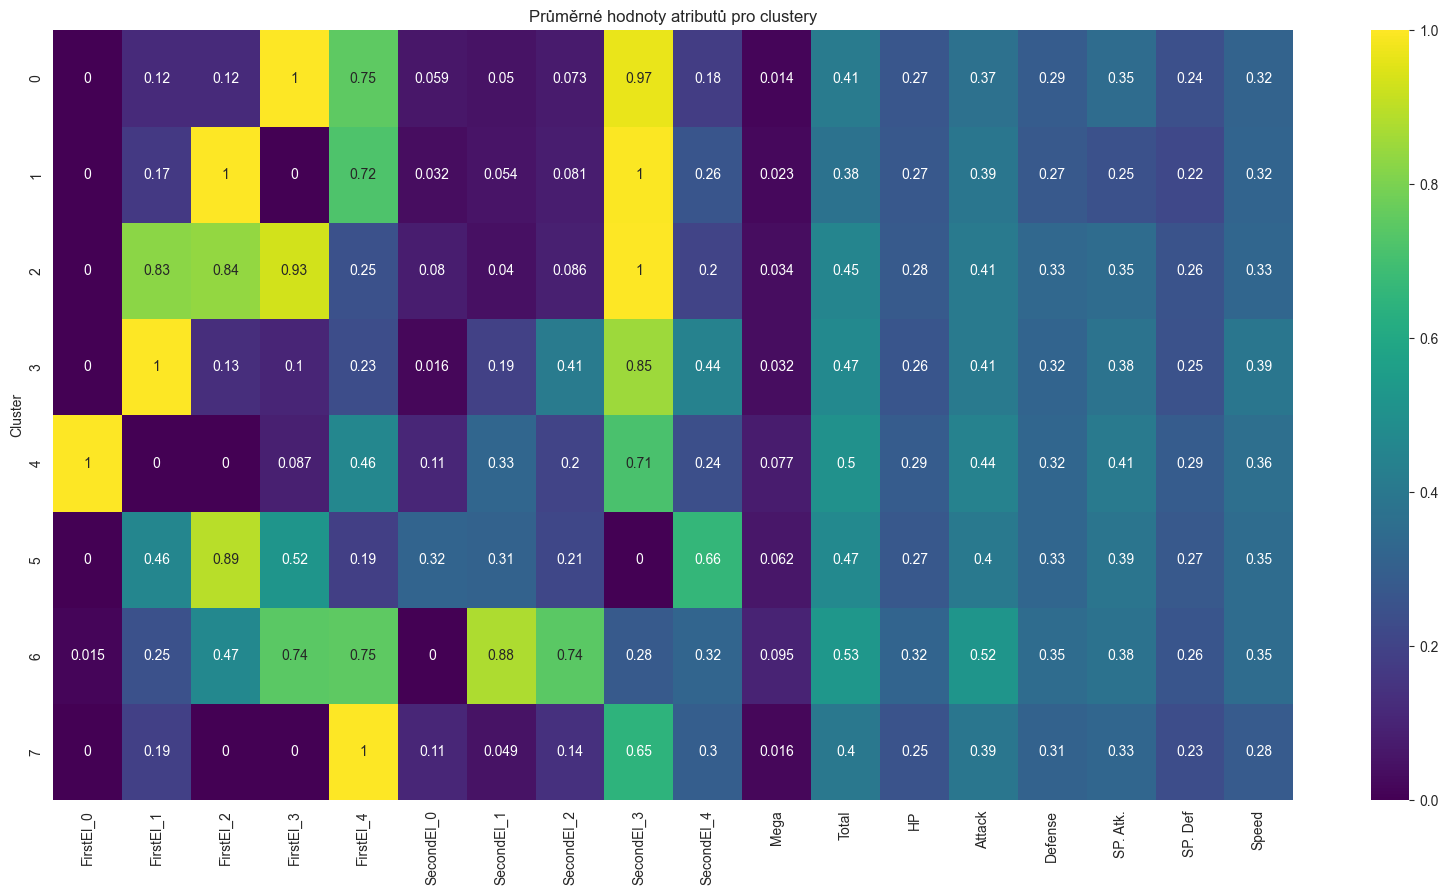

In [16]:
kmeans_data = data_encoded.copy()

kmeans = KMeans(n_clusters=8, random_state=42)
labels = kmeans.fit_predict(kmeans_data)

kmeans_data['Cluster'] = labels

cluster_means = kmeans_data.groupby('Cluster').mean()

plt.figure(figsize=(20, 10))
sns.heatmap(cluster_means, annot=True, cmap='viridis')
plt.title('Průměrné hodnoty atributů pro clustery')
plt.show()

Jak vidíme, clustering proběhl celkem dobře. Každý cluster má hodnoty ze sloupců s číselnými hodnotama a taktéž většinou obsahuje 2-4 bity, které jsou součástí kódování kategorických proměnných. 

Obecně se dá říct, že clustering se řídil okolo hlavně jednotlivých elementů, protože číselné hodnoty, které byly škálované pomocí MinMax jsou korelovány okolo 0.3-0.5, přičemž kategorické proměnné mají často velmi vysokou, nebo velmi nízkou korelaci.

Sloupec mega je víceméně kompletně ignorován.

Nyní zvolíme stejný postup, ale pomocí jiného unsupervised learning algoritmu.

Aktuálně byl proveden KMeans, a jako další zkusím zvolit SpectralClustering. 

SpectralClustering je založen na grafové vzdálenosti (graf nejbližších sousedů), přičemž KMeans používal vzdálenost mezi body.

Jako metriku kvality pro výběr počtu clusterů použijeme Silhouette skóre a calinski_harabasz index.

calinski-harabasz index nám se zvyšujícím se číslem ukazuje lepší kvalitu clusterování. 


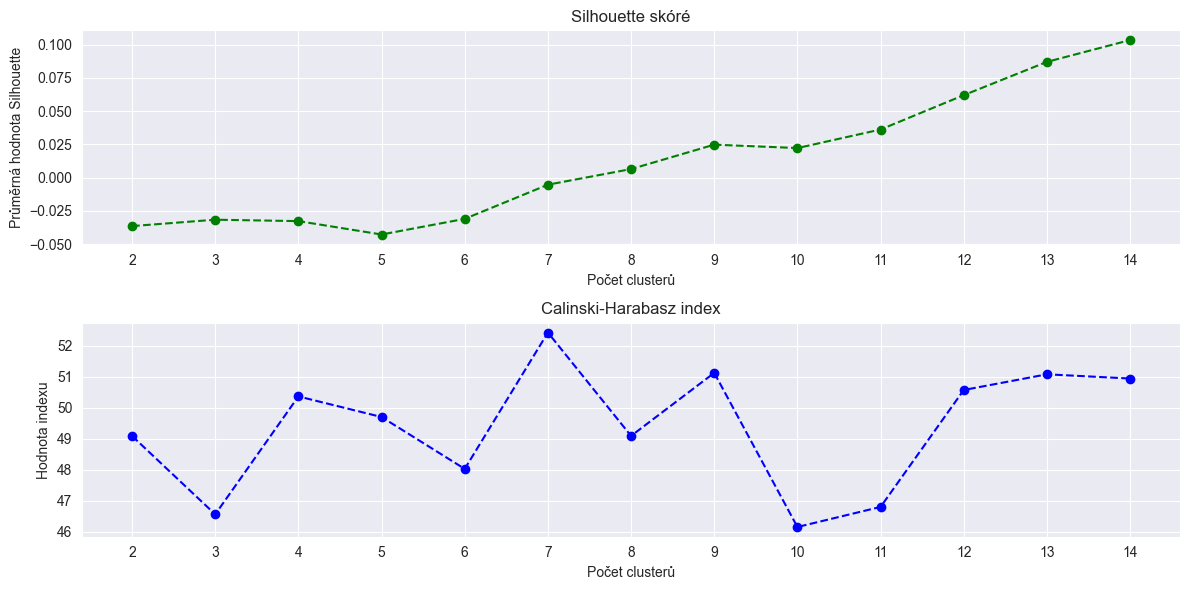

In [17]:
silhouette_avg = []  
calinski_harabasz = [] 
k_values = range(2, 15)  

for k in k_values:
    spectral = SpectralClustering(n_clusters=k, random_state=42, affinity='nearest_neighbors', n_neighbors=5)
    labels = spectral.fit_predict(data_encoded)
    
    silhouette_avg.append(silhouette_score(data_encoded, labels))
    
    calinski_harabasz.append(calinski_harabasz_score(data_encoded, labels))

plt.figure(figsize=(12, 6))

plt.subplot(2, 1, 1)
plt.plot(k_values, silhouette_avg, marker="o", linestyle="--", color="g")
plt.title("Silhouette skóré")
plt.xlabel("Počet clusterů")
plt.ylabel("Průměrná hodnota Silhouette")
plt.xticks(k_values)

plt.subplot(2, 1, 2)
plt.plot(k_values, calinski_harabasz, marker="o", linestyle="--", color="b")
plt.title("Calinski-Harabasz index")
plt.xlabel("Počet clusterů")
plt.ylabel("Hodnota indexu")
plt.xticks(k_values)

plt.tight_layout()
plt.show()

Podle calinski-harabaszova indexu určím 7 clusterů

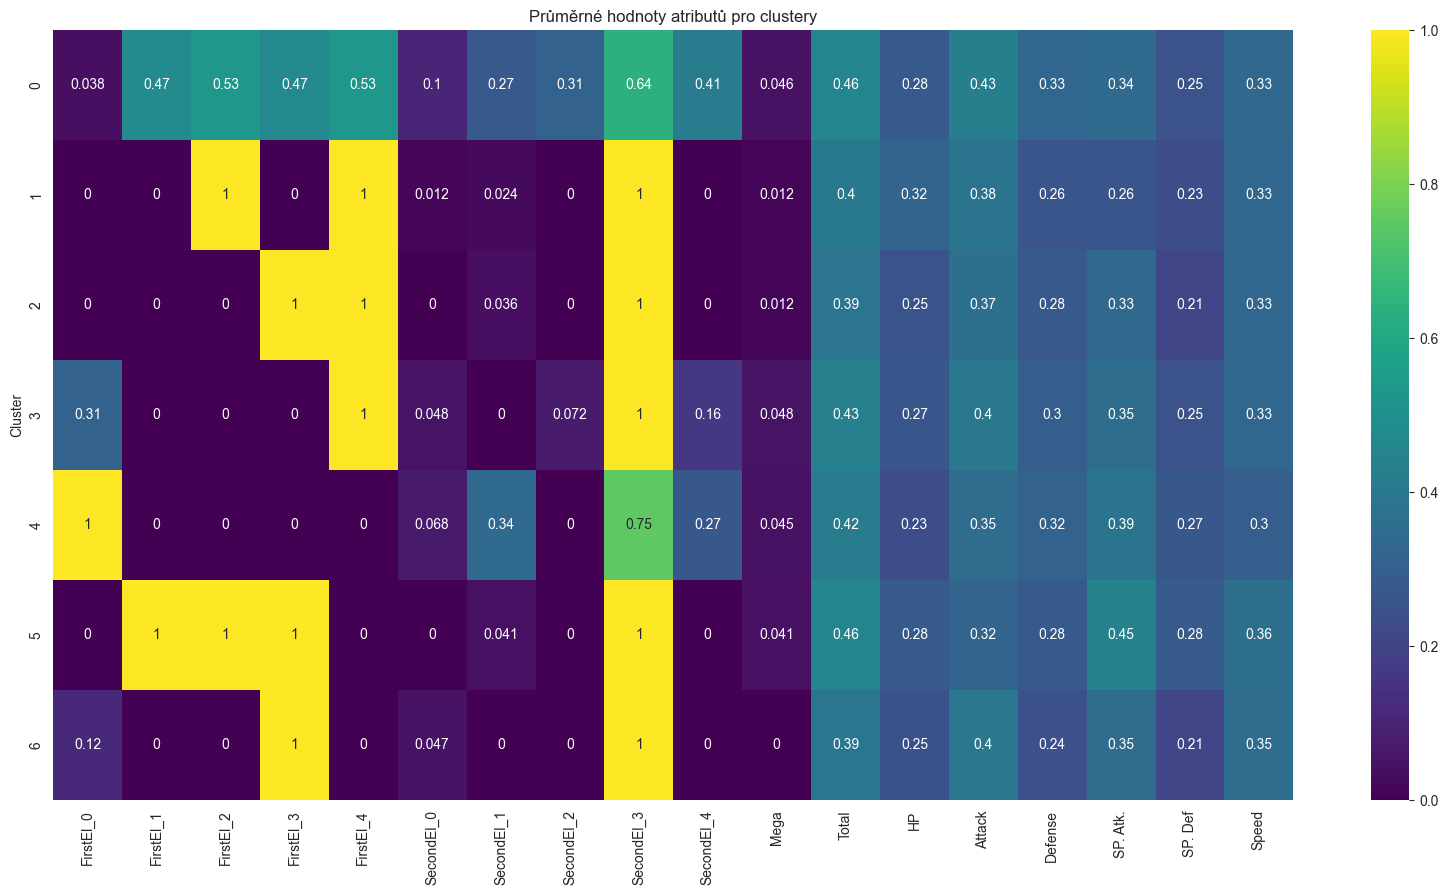

In [18]:
spectral_data = data_encoded.copy()

spectral = SpectralClustering(n_clusters=7, random_state=42, affinity='nearest_neighbors', n_neighbors=5)
labels = spectral.fit_predict(spectral_data)

spectral_data['Cluster'] = labels

cluster_means = spectral_data.groupby('Cluster').mean()

plt.figure(figsize=(20, 10))
sns.heatmap(cluster_means, annot=True, cmap='viridis')
plt.title('Průměrné hodnoty atributů pro clustery')
plt.show()

Jak můžeme vidět, SpectralClustering je více selektivní a buď vybere celý bit, nebo ho nevybere vůbec. sloupec mega je opět ignorován a číselné hodnoty škálované MinMaxem jsou opět vybírány s korelací přibližně 0.3-0.5, taktéž je zajímavé, že 1. cluster víceméně má v sobě zahrnuté skoro všechny bity jak z 1. tak z 2. elementu.

ZÁVĚR

Čistě podle mého názoru jsme v datasetu nenašli žádné věci, které by mě překvapily. Myslím si ale, že přesto analýza tohoto datasetu je užitečná např. pro sběratele či hráče a fanoušky pokémonů / pokémon GO a dalších variant těchto her. Z celé analýzy můžeme vidět trendy pokémonů pro jednotlivé statistiky, takže se dá lehce naučit, kteří pokémoni jsou dobří pro jakou situaci. 

Když budeme vědět, že nepřítel má Fighting pokémona, ze statistik rychle uvidíme, že má velké poškození a velkou obranu, hodně životů, ale velmi malou obranu proti schopnostem, tudíž by bylo dobré na něj vzít pokémona s velkým poškozením schopností, jako je např. Psychic. V datasetu to sice není zahrnuto, ale mezi elementy pokémonů jsou i určité vazby (některé elementy jsou silnější či slabší v boji oproti ostatním) a zrovna Psychic je velmi efektivní element proti fighting pokémonovi. Tudíž takto jsme si rychle mohli určit, že Psychic pokémon by mohl být dobrou volbou. Ale pro tyto účely by bylo potřeba udělat podrobnější analýzu a přidat ještě další informace do datasetu a zpracovat je, jelikož vazby mezi elementy tu nemáme.

U korelačních matic jsem nenašel taktéž žádné zajímavé postřehy, obecně distribuce jednotlivých statistik pro pokémony je velmi dobrá a vyvážená, nejsou tam žádné velké výjimky (až na 1 outliera co jsme našli a když jsem ho hledal na internetu, je víceméně brán jako nejsilnější pokémon). Což je podle mého názoru dobře, myslím si, že u takové hry by bylo kontraproduktivní mít hodně outlierů, protože by to zavádělo velké/neférové nevyrovnanosti mezi pokémony a potom by každý chtěl jen ty karty, které jsou outliery statisticky. Takto jsou pokémoni vyvážení a dobře použitelní. Taktéž nejvíce pokémonů má výskyt kolem průměru jejich celkové síly (total), a potom pod průměrem je zhruba stejný počet jak nad průměrem. To znamená, že i toto dokazuje velmi dobré vyvážení síly jednotlivých pokémonů.

U clusteringu jsem víceméně předpověděl, že clustery budou obsahovat jednotlivé atributy pokémona a potom se budou i odvíjet kolem jednotlivých elementů. Trochu mě překvapilo, že sloupec mega, který jsem přidělal, tak neměl na konečné clusterování žádný vliv. Tak nějak jsem čekal, že aspoň jeden cluster se bude odehrávat kolem dat v mega. Ale na to je podle mě moc málo záznamů (48 z 1214) aby to bylo významné pro clusterovací algoritmus. Trochu problém je s interpretačí jednotlivých algoritmů, protože elementů je hodně a máme 2 sloupce pro elementy, tudíž ve výsledném clusterování jsme měli hodně sloupců a to jsem se rozhodl redukovat nahrazení pd.dummies (OneHot) za BinaryEncoding, který tento problém zmenší za cenu čitelnosti dat, protože nyní nejsme schopni moc dobře číst kolem jakých elementů clusterování proběhlo.